# LDA Topic modelling menggunakan library gensim
Programmer: Agung Toto Wibowo (dibantu chat GPT)
Ide: berdasarkan pelajaran Systematic Mapping Studies yang diberikan oleh Bayu Erfianto

Kode ini dapat dimanfaatkan untuk mencari topik-topik penelitian yang menjadi promising Research. Langkah yang perlu dilakukan:


1.   Mengunduh bibliometric data dari scopus, IEEEexplore ataupun dari sumber lain. Format dalam bentuk CSV
2.   Mengubah beberapa parameter yang ada pada kode bagian Dataset Parameter




#Variabel program
Catatan, kode ini spesifik untuk scopus. field yang ada pada hasil pencarian sumber indexing publikasi lain bisa jadi berbeda, dan memerlukan penyesuaian.
Lakukan:

1.   Ubah pada variabel columnToProcess. Sebagai contoh kolom yang akan diproses menggunakan keywords dari author.
2.   berikan nama pada scopusFileName, dan scopus folder lokasi penyimpanan pada google drive anda
3.   Set variabel initialPath dan datasetPath sehingga cocok dengan lokasi penyimpanan di Google Drive. Pada proses running program, akan disimpan beberapa file hasil eksekusi, untuk dapat dilihat lebih lanjut diluar eksekusi.

In [ ]:
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataset parameters
#################################################################################
# UBAH BAGIAN INI SESUAI KEBUTUHAN
# Lokasi penyimpanan file oleh Agung Toto.
# Sesuaikan dengan lokasi penyimpanan file dari Bapak/Ibu Sekalian

# columnToProcess = "Title"
columnToProcess = "Keywords"
# columnToProcess = "Abstract"
isPrintKeywordsOnChart = True # untuk cetak keyword pada chart
# isPrintKeywordsOnChart = False # untuk tidak menampilkan keyword pada chart

initialPath = "/content/drive/MyDrive/S3 Informatika Fun 2324_2/Progress Report/Andy/Ujian Kualifikasi/" # Nama PATH harus sama sesuai penyimpanan pada google drive Masing-masing
scopusFolder = "Referensi 2024-05-01/"
scopusFileName = "Sub Total For LDA.xlsx"
# scopusFileName = "main.xlsx"

datasetPath = initialPath + scopusFolder

# LDA Parameters
num_topics=10
num_words_per_topics = 15

In [ ]:
df = pd.read_excel(datasetPath + scopusFileName)
#################################################################################
df.head()

,Key,Item Type,Year,Author,Title,Publication Title,ISBN,ISSN,DOI,Url,...,Programming Language,Version,System,Code,Code Number,Section,Session,Committee,History,Legislative Body
0,X7MGH3YL,conferencePaper,2023,"Rajala, Jaakko; Hukkanen, Jenni; Hartikainen, ...","""\textbackslash""Call me Kiran\textbackslash"" –...",Proceedings of the 26th International Academic...,9798400708749,NaN,10.1145/3616961.3616974,https://doi.org/10.1145/3616961.3616974,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7SQ75PUB,conferencePaper,2023,"Radensky, Marissa; Séguin, Julie Anne; Lim, Ja...","""I Think You Might Like This"": Exploring Effec...",ACM International Conference Proceeding Series,NaN,NaN,10.1145/3593013.3594043,https://www.scopus.com/inward/record.uri?eid=2...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,J5ENCYRU,journalArticle,2023,"Menon, Devadas; Shilpa, K.",“Chatting with ChatGPT”: Analyzing the factors...,Heliyon,NaN,2405-8440,https://doi.org/10.1016/j.heliyon.2023.e20962,https://www.sciencedirect.com/science/article/...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N8GYXTJK,journalArticle,2024,"Kwon, Nahyun; Sun, Tong Steven; Gao, Yuyang; Z...",3DPFIX: Improving Remote Novices' 3D Printing ...,Proc. ACM Hum.-Comput. Interact.,NaN,NaN,10.1145/3637288,https://doi.org/10.1145/3637288,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CT624PW7,journalArticle,2024,"Luo, Queenie; Puett, Michael J.; Smith, Michae...","A ""Perspectival"" Mirror of the Elephant: Inves...",Queue,NaN,1542-7730,10.1145/3649303,https://doi.org/10.1145/3649303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
!pip install pyLDAvis
!pip install statsmodels
!pip install --upgrade numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 57.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2


# Preprocess Data
Beberapa preprocessing yang dilakukan antara lain: a. stemmer, dan b. stopword removal. Preprocessing mirip dengan yang terjadi pada penelitian Sentiment Analysis.

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")

stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def clean_text(text = "default"):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    # # Stem the words
    # words = [stemmer.stem(word) for word in words]
    # Join the words back into a single string
    return " ".join(words)

# df.head()
df = df[["Year", "Title", "Abstract", "Keywords"]]
# remove blank rows
df.dropna(subset=['Year'], inplace=True)
df.dropna(subset=['Title'], inplace=True)
df.dropna(subset=['Abstract'], inplace=True)
df.dropna(subset=['Keywords'], inplace=True)

# Clean and normalize the text data
df["Keywords"] = df["Keywords"].astype(str).apply(clean_text)
df["Abstract"] = df["Abstract"].astype(str).apply(clean_text)
df["Title"] = df["Title"].astype(str).apply(clean_text)
# df.head()

# set the type
df = df.astype({"Year":'int', "Title":'string', "Abstract":'string', "Keywords":'string'})
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-5-e44288c1fa13>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['Year'], inplace=True)
<ipython-input-5-e44288c1fa13>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['Title'], inplace=True)
<ipython-input-5-e44288c1fa13>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

,Year,Title,Abstract,Keywords
0,2023,textbackslashcall kirantextbackslash chatgpt t...,natural language processing taken enormous ste...,artificial intelligence chatbots chatgpt discu...
1,2023,think might like exploring effects confidence ...,rapid growth large language models conversatio...,confidence confidence levels conversational re...
2,2023,chatting chatgpt analyzing factors influencing...,open ais chatgpt emerged popular ai language m...,acceptance use chatbots chatgpt openai utaut
3,2024,3dpfix improving remote novices 3d printing tr...,widespread consumergrade 3d printers learning ...,3d printing aidriven troubleshooting community...
5,2024,bertbased sequential poi recommender system so...,route schema challenging tourists must choose ...,bert contextaware deep neural networks persona...


# Persiapan, Running LDA, Kalkulasi hasil dan Plotting trend topik

1.   Mengambil data dataframe dan mempersiapkan corpus. Data kolom yang dipergunakan sesuai dengan inisialisasi di bagian Dataset Parameter
2.   Wordcloud ditampilkan untuk melihat distribusi masing-masing term
3.   Melakukan running LDA untuk didapatkan topik, dan menampilkan hasil running LDA pada corpus yang dipelajari secara visual.
4.   Mengkonversikan nilai setiap dokumen yang ada pada corpus dengan masing-masing topik yang dihasilkan oleh LDA
5.   Menggabungkan data tahun, judul, abstrak, keyword, dengan hasil perhitungan tiap-tiap topik. Dan menyimpan hasil pada file csv untuk dipergunakan pada luar program
6.   Mengambil top words di tiap-tiap topik yang dihasilkan oleh LDA
7.   Melakukan grouping per tahun, dan mencari nilai rata-rata per tahun untuk dilihat trend dan prediksinya
8.   Menampilkan trend penelitian di tiap-tiap topik yang dihasilkan oleh LDA





In [ ]:
# Pre-process the abstracts or titles
abstracts = [simple_preprocess(text) for text in df[columnToProcess]]

# Create the dictionary and corpus
dictionary = corpora.Dictionary(abstracts)
corpus = [dictionary.doc2bow(text) for text in abstracts]

# Apply Latent Derichlet Allocation
lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=40)

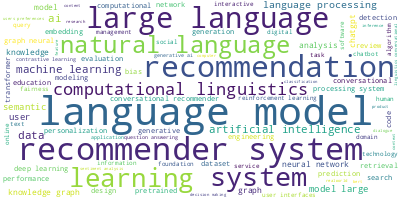

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df[columnToProcess].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
# Perform topic modeling
topics = lda.show_topics(num_words=num_words_per_topics, log=False, formatted=False)
for topic in topics:
  print(topic)

# !pip install pandas==1.5.1
#!pip install pyLDAvis --use-deprecated=backtrack-on-build-failures
# !pip install pyLDAvis
# !pip install pandas==1.5.3

# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import pickle
import os
num_topics = 10
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join(initialPath +'c1ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, initialPath +'c1ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

(0, [('knowledge', 0.034273554), ('answering', 0.01504415), ('question', 0.015044042), ('recommendation', 0.01448982), ('social', 0.012094997), ('legal', 0.012094782), ('representation', 0.011913506), ('graph', 0.010572784), ('personalization', 0.008946479), ('zeroshot', 0.008937771), ('systems', 0.007580276), ('graphs', 0.0068945982), ('media', 0.0061949263), ('algorithms', 0.0061948793), ('emotion', 0.0061948355)])
(1, [('learning', 0.03206143), ('intelligence', 0.025450576), ('artificial', 0.02535256), ('engineering', 0.02185747), ('ai', 0.02122986), ('generative', 0.018486189), ('data', 0.017333247), ('software', 0.015785888), ('language', 0.0145919), ('machine', 0.013272635), ('education', 0.012383442), ('chatgpt', 0.0106124645), ('large', 0.0105371345), ('recommendation', 0.010312825), ('model', 0.009059803)])
(2, [('language', 0.040868983), ('models', 0.030294308), ('learning', 0.024649229), ('natural', 0.019121809), ('analysis', 0.015149566), ('sentiment', 0.014837303), ('proce

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.275767 -0.041299       1        1  28.854403
5     -0.041990  0.146112       2        1  13.464089
1     -0.040887  0.141711       3        1  10.861903
8      0.065255  0.044160       4        1   9.448225
2      0.066336  0.003843       5        1   9.234926
6     -0.083445 -0.001374       6        1   7.448468
4     -0.057201 -0.029446       7        1   5.666318
3     -0.067384 -0.075560       8        1   5.113611
9     -0.014235 -0.067520       9        1   4.958639
0     -0.102216 -0.120628      10        1   4.949417, topic_info=         Term        Freq       Total Category  logprob  loglift
17   language  163.000000  163.000000  Default  30.0000  30.0000
21      model  117.000000  117.000000  Default  29.0000  29.0000
183      data   34.000000   34.000000  Default  28.0000  28.0000
28    systems  107.000000  107.000000  Default  27.0000  27.0000
125     graph   34.000000   34.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
46   networks    1.399950   14.407061  Topic10  -5.0841   0.6746
116   network    1.399955   16.904169  Topic10  -5.0841   0.5148
47     neural    1.399965   21.453629  Topic10  -5.0840   0.2765
28    systems    1.713070  107.632208  Topic10  -4.8822  -1.1345
0          ai    1.399947   42.812661  Topic10  -5.0841  -0.4145

[612 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
205       7  0.472898        ab
721       7  0.699689  abnormal
130       1  0.215376    access
130       4  0.430753    access
130       9  0.215376    access
...     ...       ...       ...
588       3  0.138984  zeroshot
588       6  0.138984  zeroshot
588       7  0.138984  zeroshot
588       8  0.138984  zeroshot
588      10  0.277968  zeroshot

[944 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 2, 9, 3, 7, 5, 4, 10, 1])

In [ ]:
# mengkonversikan nilai setiap dokumen yang ada pada corpus dengan masing-masing topik yang dihasilkan oleh LDA

corpusTopic = lda[corpus]
print(corpusTopic)
import numpy as np
zero_data = np.zeros(shape=(len(corpusTopic), num_topics))
pdTopics = pd.DataFrame(zero_data)
print(len(corpusTopic[0]))
for i in range(len(corpusTopic)):
  for j in range(len(corpusTopic[i])):
    try:
      pdTopics.at[i, int(corpusTopic[i][j][0])] = corpusTopic[i][j][1]
    except:
      print("Skip pada dokumen ke", i)
pdTopics.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1


,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.930761,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.649166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.314466,0.000000,0.000000
2,0.014286,0.014288,0.014287,0.014287,0.871419,0.014287,0.014286,0.014288,0.014287,0.014286
3,0.000000,0.930763,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.514685,0.000000,0.000000,0.000000,0.412500,0.000000,0.000000,0.000000


In [ ]:
# Menggabungkan data tahun, judul, abstrak, keyword, dengan hasil perhitungan tiap-tiap topik. Dan menyimpan hasil pada file csv untuk dipergunakan pada luar program

df['Used Column'] = columnToProcess
df_TopicModelling = pd.concat([df, pdTopics], axis=1, join="inner")
df_TopicModelling.to_csv(datasetPath+"topicModellingResult.csv", sep = ';', decimal= ",")
df_TopicModelling.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Year,Title,Abstract,Keywords,Used Column,0,1,2,3,4,5,6,7,8,9
0,2023,textbackslashcall kirantextbackslash chatgpt t...,natural language processing taken enormous ste...,artificial intelligence chatbots chatgpt discu...,Keywords,0.000000,0.930761,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2023,think might like exploring effects confidence ...,rapid growth large language models conversatio...,confidence confidence levels conversational re...,Keywords,0.649166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.314466,0.000000,0.000000
2,2023,chatting chatgpt analyzing factors influencing...,open ais chatgpt emerged popular ai language m...,acceptance use chatbots chatgpt openai utaut,Keywords,0.014286,0.014288,0.014287,0.014287,0.871419,0.014287,0.014286,0.014288,0.014287,0.014286
3,2024,3dpfix improving remote novices 3d printing tr...,widespread consumergrade 3d printers learning ...,3d printing aidriven troubleshooting community...,Keywords,0.000000,0.930763,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2024,bertbased sequential poi recommender system so...,route schema challenging tourists must choose ...,bert contextaware deep neural networks persona...,Keywords,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.924989,0.000000


In [ ]:
# mengambil top words di tiap-tiap topik yang dihasilkan oleh LDA
top_words_per_topic = []
for t in range(lda.num_topics):
  top_words_per_topic.extend([(t, ) + x for x in lda.show_topic(t, topn = num_words_per_topics)])
# print(top_words_per_topic)
pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv(datasetPath+"top_words.csv")

df_top_words_per_topic = pd.DataFrame(top_words_per_topic)
df_top_words_per_topic.columns = ["Topik", "Keywords", "distribusi"]
df_top_words_per_topic.head()

df_keywords = df_top_words_per_topic.groupby('Topik')['Keywords'].apply(lambda x:x.str.cat(sep=", "))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_TopicModelling_2 = df_TopicModelling.drop(columns=['Title', 'Abstract', 'Keywords', 'Used Column'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

df_grouped = df_TopicModelling_2.groupby('Year')
df_mean_grouped = df_grouped.mean()
# df_mean_grouped.head()
df_mean_grouped.reset_index(inplace=True)
df_mean_grouped.columns = df_mean_grouped.columns.map(str)
df_mean_grouped.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Year,0,1,2,3,4,5,6,7,8,9
0,2021,0.116875,0.001250,0.233837,0.001251,0.001251,0.033758,0.001251,0.220665,0.328708,0.001250
1,2022,0.004979,0.206727,0.174327,0.004979,0.098001,0.084913,0.091583,0.301355,0.004980,0.004980
2,2023,0.056704,0.112775,0.069938,0.091499,0.054751,0.147889,0.106456,0.181995,0.099465,0.052003
3,2024,0.060029,0.084544,0.076062,0.062300,0.079545,0.167259,0.069995,0.195454,0.107000,0.073777


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


knowledge, answering, question, recommendation, social, legal, representation, graph, personalization, zeroshot, systems, graphs, media, algorithms, emotion
learning, intelligence, artificial, engineering, ai, generative, data, software, language, machine, education, chatgpt, large, recommendation, model
language, models, learning, natural, analysis, sentiment, processing, large, retrieval, graph, pretrained, knowledge, data, machine, extraction
model, outcome, approximate, deep, ai, network, neural, search, neighbor, nearest, learning, analysis, explainable, gpt, filtering
network, learning, chatgpt, collaborative, systems, recommender, system, recommendation, explainability, filtering, graph, bias, detection, dialogue, attention
learning, intelligence, artificial, ai, recommendation, machine, systems, language, models, explainable, recommender, review, modeling, bias, classification
graph, learning, neural, networks, knowledge, recommendation, machine, deep, engineering, graphs, desi

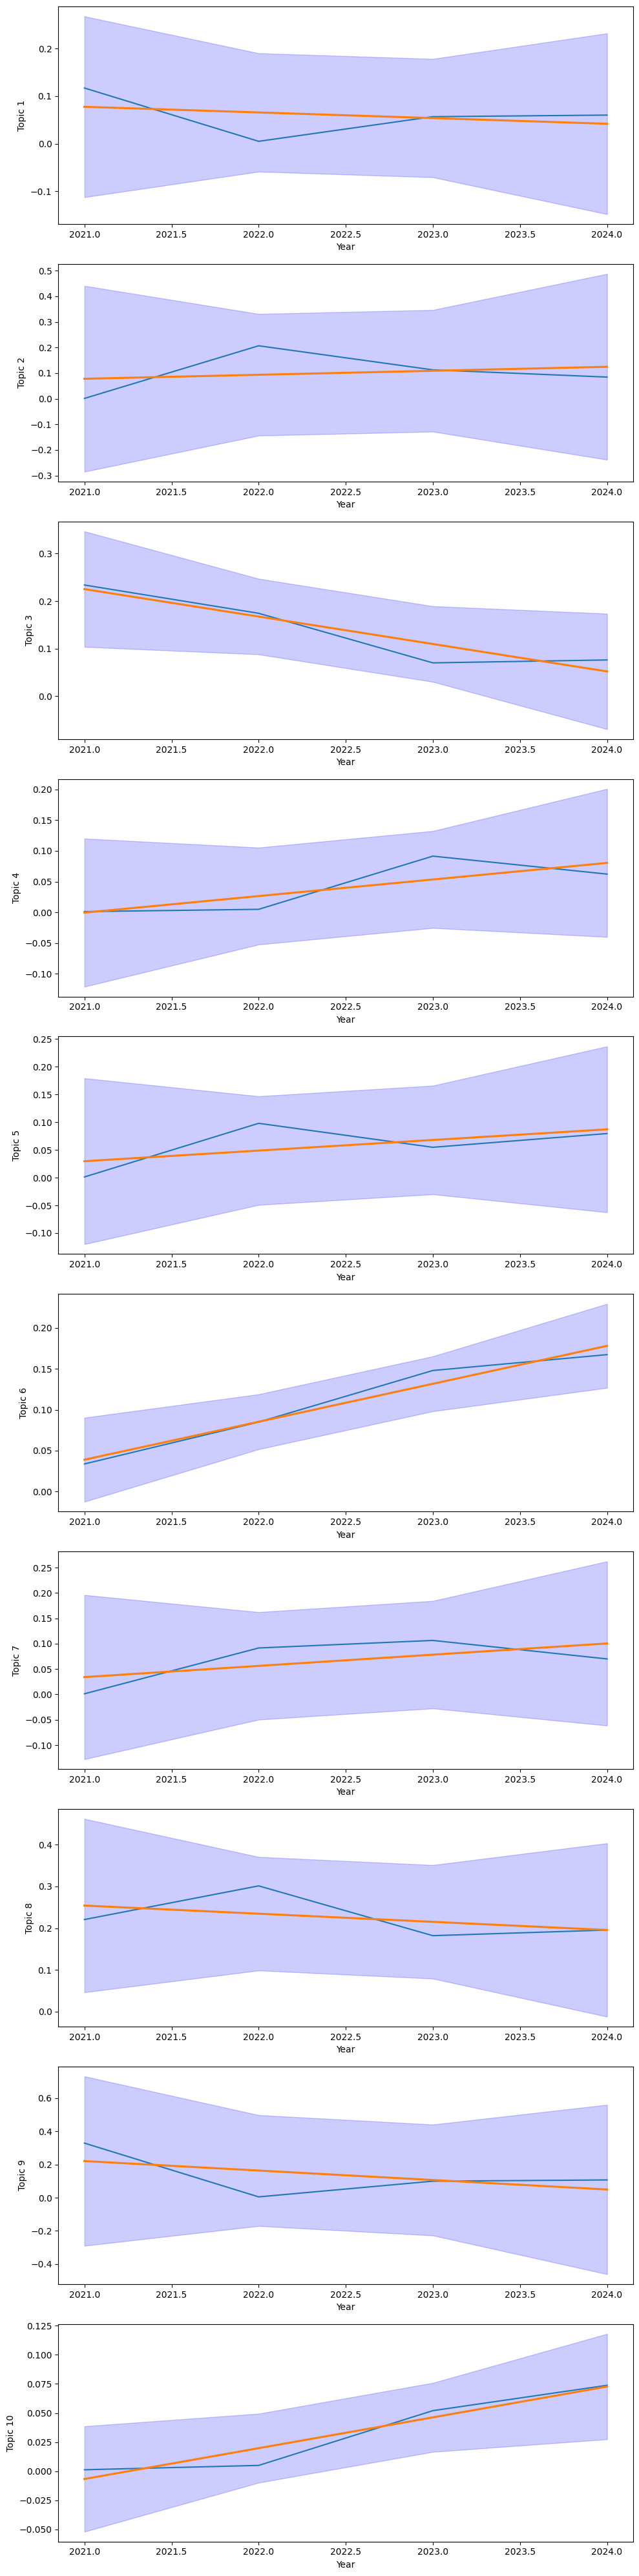

In [ ]:
# Menampilkan trend penelitian di tiap-tiap topik yang dihasilkan oleh LDA

# Get the list of column names
columns_to_plot = df_mean_grouped.columns[1:]  # Skip the first column

# Set up subplots
fig, axes = plt.subplots(nrows=len(columns_to_plot), figsize=(10, 4 * len(columns_to_plot)))
# descriptions = ['Note for Topic 1', 'Note for Topic 2', 'Note for Topic 3', 'Note for Topic 1', 'Note for Topic 2', 'Note for Topic 3', 'Note for Topic 1', 'Note for Topic 2', 'Note for Topic 3', 'Note for Topic 1', 'Note for Topic 2', 'Note for Topic 3']

# Iterate over columns and create separate plots
for i, column in enumerate(columns_to_plot):
    # Plot the mean values for each year
    sns.lineplot(x='Year', y=column, data=df_mean_grouped, ax=axes[i])

    # Calculate prediction interval
    X = sm.add_constant(df_mean_grouped['Year'])
    model = sm.OLS(df_mean_grouped[column], X).fit()
    y_pred = model.get_prediction(X).summary_frame(alpha=0.05)

    # Plot prediction interval
    axes[i].fill_between(df_mean_grouped['Year'], y_pred['mean_ci_lower'], y_pred['mean_ci_upper'], color='blue', alpha=0.2)

    # # Add trend lines (regression lines)
    sns.regplot(x='Year', y=column, data=df_mean_grouped, ci=None, scatter=False, ax=axes[i])
    # Add trend lines (regression lines) with confidence intervals
    # sns.regplot(x='Year', y=column, data=df_mean_grouped, ci=95, ax=axes[i])

    # Set y-axis label
    axes[i].set_ylabel('Topic {}'.format(i+1))
    if (isPrintKeywordsOnChart == True):
      axes[i].text(0.5, 0.95, "", transform=axes[i].transAxes, ha='center', va='top', bbox=dict(boxstyle='round', alpha=0.1))
      print(df_keywords[i])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()